In [170]:

# run from python
import scripts.label_image
import sys
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw, ImageFont
import time
import psutil
import pandas as pd


def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()
  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)
  return graph


def read_tensor_from_image_file(file_name, input_height=299, input_width=299,
				input_mean=0, input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
  else:
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0);
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)
  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label


input_height = 224
input_width = 224
input_mean = 128
input_std = 128
input_layer = "input"
output_layer = "final_result"
label_file = r'/home/mmann1123/Documents/PiCameraClassifier/tf_files/retrained_labels_mobilenet_1.0_224.txt'
model_file = r'/home/mmann1123/Documents/PiCameraClassifier/tf_files/retrained_graph_mobilenet_1.0_224.pb'
 

###############################
# iterate across series of photos 

# set up storage for classifications
df = pd.DataFrame(columns=['Path','Date','Class','Prob'])
row = 0

os.chdir(r'/home/mmann1123/Dropbox/Apps/PiCameraLogger/')
rootdir = os.getcwd()

for dir, dirs, files in os.walk(rootdir):
    for file in files:
        if file == '.dropbox': 
            continue
        file_name = os.path.join(dir, file)
        graph = load_graph(model_file)
        t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,input_mean=input_mean,input_std=input_std)
        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)
        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0],
                  {input_operation.outputs[0]: t})
        results = np.squeeze(results)
        top_k = results.argsort()[-5:][::-1]
        labels = load_labels(label_file)
        image = Image.open( file_name)
        font_type = ImageFont.truetype('/home/mmann1123/Documents/Fonts/unifont-10.0.07.ttf',25)
        draw = ImageDraw.Draw(image)
        draw.text(xy =(50,50),text=labels[top_k[0]]+' '+np.array2string(results[top_k[0]]),fill=(255,255,255), font=font_type)
        #image.show()
        #print(file_name)
        #store path class date
        file_name2 = os.path.splitext(file_name)[0]
        date_in = file_name2.split("Picapture_")[1]
        date_time = datetime.strptime(date_in, "%d_%m_%Y-%H:%M:%S")
        df.loc[row] = [file_name,date_time,labels[top_k[0]],results[top_k[0]] ]
        row += 1
        print(labels[top_k[0]], results[top_k[0]])


('bus', 0.98346323)
('car', 0.43198314)
('car', 0.7259174)
('car2', 0.38886929)
('car2', 0.40992376)
('largecar', 0.28378931)
('car2', 0.38002771)
('fedex', 0.77163786)
('fedex', 0.30659378)
('fedex', 0.32907104)
('car', 0.52165735)
('fedex', 0.63951313)
('car', 0.77035534)
('car2', 0.34251159)
('bus', 0.99481791)
('car2', 0.38995647)
('largecar', 0.59384817)
('fedex', 0.2852897)
('fedex', 0.81082594)
('largecar', 0.35215017)
('car2', 0.79473031)
('car', 0.37020487)
('car', 0.4337365)
('car', 0.73893416)
('car', 0.36800992)
('bus', 0.51024765)
('bus', 0.43069178)
('fedex', 0.26752901)
('fedex', 0.51511949)
('fedex', 0.7089259)
('fedex', 0.87018359)
('car2', 0.70227867)
('car', 0.71066773)
('largecar', 0.36511168)
('car', 0.35567608)
('fedex', 0.93709707)
('fedex', 0.48784518)
('car3', 0.36273181)
('car', 0.47401652)
('car', 0.73038697)
('car2', 0.36001539)
('car2', 0.45088205)
('junk', 0.95459473)
('car2', 0.35112071)
('fedex', 0.71836638)
('car2', 0.56730211)
('car', 0.78895289)
('car

('car2', 0.290373)
('fedex', 0.35923773)
('largecar', 0.72259426)
('car2', 0.4116326)
('bus', 0.88121611)
('fedex', 0.32423255)
('car3', 0.48650697)
('fedex', 0.3655051)
('fedex', 0.30700266)
('car2', 0.35219562)
('car3', 0.48780176)
('fedex', 0.34486046)
('car2', 0.30690938)
('junk', 0.8905161)
('fedex', 0.32721445)
('car2', 0.25901538)
('car2', 0.33115521)
('fedex', 0.30580702)
('car2', 0.28324693)
('fedex', 0.32600859)
('car2', 0.31626171)
('fedex', 0.38755336)
('car', 0.28505179)
('car2', 0.52363408)
('largecar', 0.54244155)
('car2', 0.36416736)
('junk', 0.98403889)
('bus', 0.71270573)
('car3', 0.38082176)
('bus', 0.97439504)
('fedex', 0.44915605)
('car2', 0.32962748)
('largecar', 0.31373531)
('car2', 0.34427899)
('fedex', 0.36889768)
('fedex', 0.30866402)
('car', 0.36689574)
('fedex', 0.31375787)
('car2', 0.29105932)
('fedex', 0.37397194)
('fedex', 0.3231017)
('fedex', 0.52092165)
('fedex', 0.58802772)
('car', 0.40034503)
('largecar', 0.41301382)
('junk', 0.72950161)
('car3', 0.31

In [171]:
df.head()

,Path,Date,Class,Prob
0,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,2018-03-15 07:58:00,bus,0.983463
1,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,2018-03-15 09:30:00,car,0.431983
2,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,2018-03-15 10:58:00,car,0.725917
3,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,2018-03-15 07:46:00,car2,0.388869
4,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,2018-03-15 08:00:00,car2,0.409924


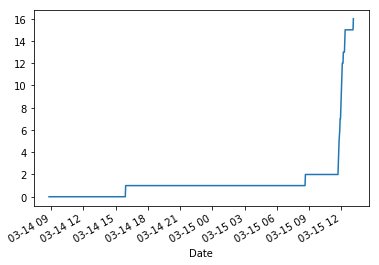

In [192]:
df.index  = df.Date
df.sort_index(inplace=True)
fedex = df.copy()
fedex = fedex.assign(Count=pd.Series([0] * len(fedex['Date'])).values)
fedex.loc[(fedex.Prob > 0.85) & (fedex.Class == 'fedex') ,'Count' ] =1
fedex = fedex.assign(CumSum=pd.Series(fedex.Count.cumsum()  ).values)
fedex.head(500)
fedex.CumSum.plot()



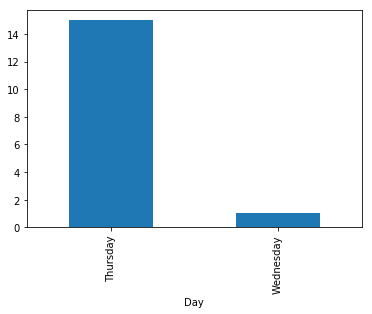

In [195]:
fedex = fedex.assign(Day=pd.Series(fedex.index.strftime('%A')).values)
fedex[['Day', 'Count']].groupby('Day').sum().plot(kind='bar', legend=None)



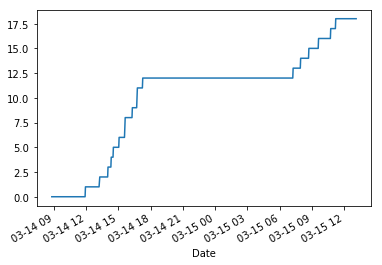

In [196]:
df.index  = df.Date
df.sort_index(inplace=True)
fedex = df.copy()
fedex = fedex.assign(Count=pd.Series([0] * len(fedex['Date'])).values)
fedex.loc[(fedex.Prob > 0.85) & (fedex.Class == 'bus') ,'Count' ] =1
fedex = fedex.assign(CumSum=pd.Series(fedex.Count.cumsum()  ).values)
fedex.head(500)
fedex.CumSum.plot()
 

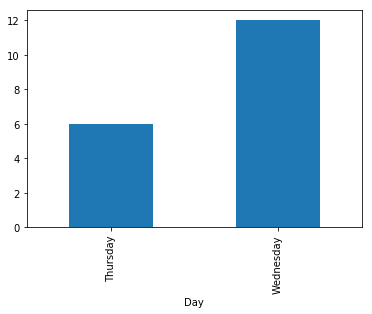

In [197]:
fedex = fedex.assign(Day=pd.Series(fedex.index.strftime('%A')).values)
fedex[['Day', 'Count']].groupby('Day').sum().plot(kind='bar', legend=None)
